C:\Users\菅野皓太\AppData\Local\Temp\ipykernel_40896\804066206.py:135: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_df = X_df.fillna(method="bfill").fillna(method="ffill").fillna(0.0)
C:\Users\菅野皓太\AppData\Local\Temp\ipykernel_40896\804066206.py:135: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_df = X_df.fillna(method="bfill").fillna(method="ffill").fillna(0.0)
C:\Users\菅野皓太\AppData\Local\Temp\ipykernel_40896\804066206.py:135: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_df = X_df.fillna(method="bfill").fillna(method="ffill").fillna(0.0)
C:\Users\菅野皓太\AppData\Local\Temp\ipykernel_40896\804066206.py:135: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffil

[INFO] 使用キーポイント実名: ['left back paw', 'right back paw', 'left front paw', 'right front paw', 'tail set']
X: (5082, 30, 10) y: (5082,) files: 116
class_weight: {0: 0.8777777777777778, 1: 1.161764705882353}
Epoch 1/50


C:\Users\菅野皓太\AppData\Local\Temp\ipykernel_40896\804066206.py:135: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_df = X_df.fillna(method="bfill").fillna(method="ffill").fillna(0.0)
C:\Users\菅野皓太\AppData\Local\Temp\ipykernel_40896\804066206.py:135: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_df = X_df.fillna(method="bfill").fillna(method="ffill").fillna(0.0)
C:\Users\菅野皓太\AppData\Local\Temp\ipykernel_40896\804066206.py:135: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_df = X_df.fillna(method="bfill").fillna(method="ffill").fillna(0.0)
C:\Users\菅野皓太\AppData\Local\Temp\ipykernel_40896\804066206.py:135: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffil

114/124 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6407 - loss: 0.6532
Epoch 1: val_accuracy improved from -inf to 0.63428, saving model to C:\kanno\vscode\RNN-for-Human-Activity-Recognition-using-2D-Pose-Input-master\RNN-for-Human-Activity-Recognition-using-2D-Pose-Input-master\data\ivdd\train\checkpoints\best.keras
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6459 - loss: 0.6477 - val_accuracy: 0.6343 - val_loss: 0.7086 - learning_rate: 0.0010
Epoch 2/50
123/124 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8432 - loss: 0.3984
Epoch 2: val_accuracy improved from 0.63428 to 0.72261, saving model to C:\kanno\vscode\RNN-for-Human-Activity-Recognition-using-2D-Pose-Input-master\RNN-for-Human-Activity-Recognition-using-2D-Pose-Input-master\data\ivdd\train\checkpoints\best.keras
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8434 - loss: 0.3979 - val_accuracy: 0.7226 - val_loss: 0.6678 - learning_rate: 0.0010
Epoch 3/50
115/124 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accu

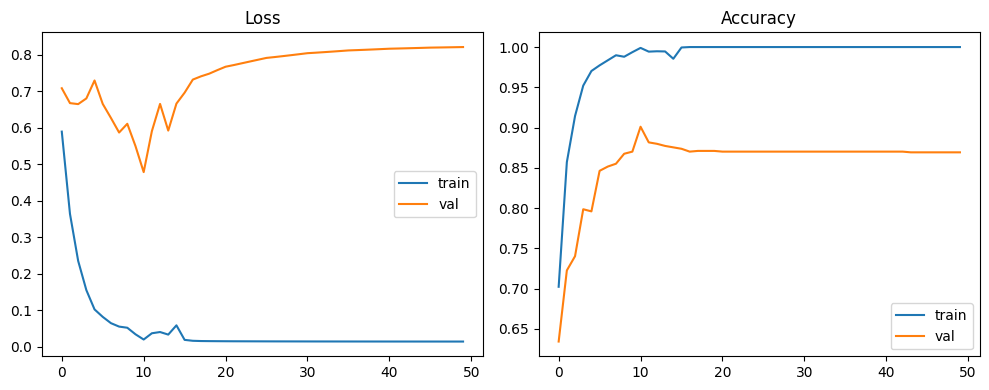

Saved model to: C:\kanno\vscode\RNN-for-Human-Activity-Recognition-using-2D-Pose-Input-master\RNN-for-Human-Activity-Recognition-using-2D-Pose-Input-master\data\ivdd\train\ivdd_lstm_final.keras


In [8]:
# -*- coding: utf-8 -*-
"""
IVDD binary classification (2-class: ivdd / normal) from DeepLabCut CSV (3-level header)
- 5 keypoints × (x,y) = 10 dims を使用（likelihood 低品質点は補間）
- Windowing: SEQ_LEN=30, STRIDE=5
- Model: TimeDistributed(Dense->ReLU) -> LSTM -> LSTM -> Dense(2 logits)
- 学習率は固定（Adam(LR)）。ReduceLROnPlateau で停滞時のみ減衰。
"""

import os
import re
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# ========= 設定 =========
DATA_DIR   = r"C:\kanno\vscode\RNN-for-Human-Activity-Recognition-using-2D-Pose-Input-master\RNN-for-Human-Activity-Recognition-using-2D-Pose-Input-master\data\ivdd\train"                 # CSV を置くフォルダ
CSV_GLOB   = os.path.join(DATA_DIR, "*.csv")

# ★ 指定の5点（ユーザー指定）
KEYPOINTS = [
    "left back paw",
    "right back paw",
    "left front paw",
    "right front paw",
    "tail set",
]

# 前処理系
USE_LIKELIHOOD       = True
MIN_KEEP_LIKELIHOOD  = 0.6

# 窓切り
SEQ_LEN   = 30
STRIDE    = 5
DIMS      = 10                 # 5点×(x,y)
BATCH_SIZE = 32
EPOCHS     = 50

# 最適化
LR = 1e-3                      # ★ 固定学習率（ReduceLROnPlateau と競合しない）
VAL_SPLIT_BY_FILE = True       # ファイル単位でtrain/val分割（リーク防止）

# 2クラス
CLASS_NAMES  = ["ivdd", "normal"]
CLASS_TO_IDX = {c:i for i,c in enumerate(CLASS_NAMES)}
N_CLASSES    = 2

# 再現性（任意）
tf.random.set_seed(42)
np.random.seed(42)

# ========= ユーティリティ =========
def _norm_name(s: str) -> str:
    return "".join(ch for ch in s.lower() if ch not in " _-")

def _resolve_keypoints(all_bodyparts, requested):
    norm2orig = {}
    for bp in all_bodyparts:
        k = _norm_name(bp)
        if k not in norm2orig:
            norm2orig[k] = bp
    resolved, missing = [], []
    for req in requested:
        k = _norm_name(req)
        if k in norm2orig:
            resolved.append(norm2orig[k])
        else:
            missing.append(req)
    if missing:
        raise ValueError(f"指定キーポイントがCSVで見つかりません: {missing}\n利用可能: {all_bodyparts}")
    return resolved

def infer_label_from_filename(filename: str) -> int:
    """
    'ivdd' / 'normal' を「単語」として判定。
    例: 'IvddOct30' は無視、'ivdd_...' や '..._normal_' は一致。
    """
    base = os.path.basename(filename).lower()
    ivdd_match   = re.search(r'(?<![a-z])ivdd(?![a-z])', base, flags=re.I)
    normal_match = re.search(r'(?<![a-z])normal(?![a-z])', base, flags=re.I)

    if ivdd_match and not normal_match:
        return CLASS_TO_IDX["ivdd"]
    if normal_match and not ivdd_match:
        return CLASS_TO_IDX["normal"]

    # フォールバック：先頭トークン
    token = re.split(r'[_\-.]', base)[0]
    if token in CLASS_TO_IDX:
        return CLASS_TO_IDX[token]
    raise ValueError(f"ラベルを特定できません: {filename}（'ivdd' または 'normal' を単語として含めてください）")

def read_dlc_5kp_xy(csv_path: str,
                    keypoints,
                    use_likelihood=True,
                    min_keep_likelihood=0.6):
    """
    DLCの3段ヘッダCSVを読み込み、指定5点の (x,y) だけを抽出して (N,10) を返す。
    likelihood < 閾値 の (x,y) は NaN → 線形補間。
    """
    df = pd.read_csv(csv_path, header=[0,1,2], index_col=0)
    bodyparts = list({bp for (_, bp, _) in df.columns})
    use_kps = _resolve_keypoints(bodyparts, keypoints)

    # (x,y) を抽出
    cols = {}
    for bp in use_kps:
        cols[f"{bp}_x"] = df.xs((bp, "x"), level=[1,2], axis=1)
        cols[f"{bp}_y"] = df.xs((bp, "y"), level=[1,2], axis=1)
    X_df = pd.concat(cols.values(), axis=1)
    X_df.columns = list(cols.keys())

    # likelihood で品質管理
    if use_likelihood:
        for bp in use_kps:
            try:
                lcol = df.xs((bp, "likelihood"), level=[1,2], axis=1).values.flatten()
                low = lcol < min_keep_likelihood
                for c in [f"{bp}_x", f"{bp}_y"]:
                    vals = X_df[c].values
                    vals[low] = np.nan
                    X_df[c] = vals
            except KeyError:
                pass

    # 線形補間→前後補完→0埋め
    X_df = X_df.interpolate(method="linear", limit_direction="both", axis=0)
    X_df = X_df.fillna(method="bfill").fillna(method="ffill").fillna(0.0)

    X = X_df.values.astype(np.float32)          # (N, 10)
    return X, use_kps

def zscore_per_file(X: np.ndarray, eps: float=1e-6) -> np.ndarray:
    mu = X.mean(axis=0, keepdims=True)
    sd = X.std(axis=0, keepdims=True)
    return (X - mu) / (sd + eps)

def make_windows(X: np.ndarray, seq_len: int, stride: int) -> np.ndarray:
    n = X.shape[0]
    if n < seq_len:
        return np.empty((0, seq_len, X.shape[1]), dtype=X.dtype)
    starts = range(0, n - seq_len + 1, stride)
    return np.stack([X[s:s+seq_len] for s in starts], axis=0)

def build_dataset(csv_paths, seq_len=SEQ_LEN, stride=STRIDE):
    X_list, y_list, file_ids = [], [], []
    used_kps_any = None

    for p in csv_paths:
        y_lab = infer_label_from_filename(p)

        X_raw, used_kps = read_dlc_5kp_xy(
            p,
            keypoints=KEYPOINTS,
            use_likelihood=USE_LIKELIHOOD,
            min_keep_likelihood=MIN_KEEP_LIKELIHOOD
        )
        if X_raw.shape[1] != DIMS:
            raise ValueError(f"{os.path.basename(p)}: 取り出し次元 {X_raw.shape[1]} が期待の {DIMS} と違います")

        X_raw = zscore_per_file(X_raw)
        X_win = make_windows(X_raw, seq_len, stride)   # (M, T, D)
        if X_win.shape[0] == 0:
            print(f"[WARN] {os.path.basename(p)}: フレーム不足（{seq_len}未満）でスキップ")
            continue

        X_list.append(X_win)
        y_list.append(np.full((X_win.shape[0],), y_lab, dtype=np.int64))
        file_ids += [os.path.basename(p)]*X_win.shape[0]
        used_kps_any = used_kps

    if not X_list:
        raise RuntimeError("データが作れませんでした。CSV と命名規則（ivdd/normal）を確認してください。")
    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    file_ids = np.array(file_ids)
    print(f"[INFO] 使用キーポイント実名: {used_kps_any}")
    return X, y, file_ids

# ========= モデル（構造そのまま＋L2） =========
class LSTM_RNN(keras.Model):
    def __init__(self, n_input, n_hidden, n_classes):
        super().__init__()
        self.input_dense = keras.layers.Dense(n_hidden, activation='relu')
        self.time_dist   = keras.layers.TimeDistributed(self.input_dense)
        self.lstm1 = keras.layers.LSTM(n_hidden, return_sequences=True)
        self.lstm2 = keras.layers.LSTM(n_hidden)
        self.out   = keras.layers.Dense(n_classes)  # logits

    def call(self, x, training=False):
        x = self.time_dist(x)
        x = self.lstm1(x, training=training)
        x = self.lstm2(x, training=training)
        x = self.out(x)
        return x

class LSTMWithL2(LSTM_RNN):
    def __init__(self, n_input, n_hidden, n_classes, l2_lambda=1e-4):
        super().__init__(n_input, n_hidden, n_classes)
        self.l2_lambda   = l2_lambda
        self.loss_fn     = keras.losses.CategoricalCrossentropy(from_logits=True)
        self.metric_acc  = keras.metrics.CategoricalAccuracy(name="accuracy")
        self.metric_loss = keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        # Keras に登録（自動で reset_state される）
        return [self.metric_loss, self.metric_acc]

    def compile(self, optimizer, **kwargs):
        super().compile(optimizer=optimizer, **kwargs)

    def _l2(self):
        if not self.trainable_variables:
            return 0.0
        return self.l2_lambda * tf.add_n([tf.nn.l2_loss(v) for v in self.trainable_variables])

    def train_step(self, data):
        # class_weight を使うと (x,y,sample_weight) が来ることがある
        if isinstance(data, (list, tuple)) and len(data) == 3:
            x, y, sample_weight = data
        else:
            x, y = data
            sample_weight = None

        with tf.GradientTape() as tape:
            logits = self(x, training=True)
            loss = self.loss_fn(y, logits, sample_weight=sample_weight) + self._l2()

        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        self.metric_loss.update_state(loss)
        self.metric_acc.update_state(y, logits, sample_weight=sample_weight)
        return {"loss": self.metric_loss.result(), "accuracy": self.metric_acc.result()}

    def test_step(self, data):
        if isinstance(data, (list, tuple)) and len(data) == 3:
            x, y, sample_weight = data
        else:
            x, y = data
            sample_weight = None

        logits = self(x, training=False)
        loss = self.loss_fn(y, logits, sample_weight=sample_weight) + self._l2()

        self.metric_loss.update_state(loss)
        self.metric_acc.update_state(y, logits, sample_weight=sample_weight)
        return {"loss": self.metric_loss.result(), "accuracy": self.metric_acc.result()}

# ========= データ読み込み & 学習 =========
csv_files  = sorted(glob.glob(CSV_GLOB))
if not csv_files:
    raise FileNotFoundError(f"CSV が見つかりません: {CSV_GLOB}")

X, y, file_ids = build_dataset(csv_files, SEQ_LEN, STRIDE)
print("X:", X.shape, "y:", y.shape, "files:", len(np.unique(file_ids)))

# one-hot
y_oh = keras.utils.to_categorical(y, num_classes=N_CLASSES)

# ファイルリーク防止の分割
if VAL_SPLIT_BY_FILE:
    uniq = np.unique(file_ids)
    tr_files, va_files = train_test_split(uniq, test_size=0.2, random_state=42, shuffle=True)
    tr_mask = np.isin(file_ids, tr_files)
    va_mask = np.isin(file_ids, va_files)
    X_train, y_train = X[tr_mask], y_oh[tr_mask]
    X_val,   y_val   = X[va_mask], y_oh[va_mask]
else:
    X_train, X_val, y_train, y_val = train_test_split(X, y_oh, test_size=0.2, random_state=42, stratify=y)

# クラス不均衡対策
cls_w = compute_class_weight("balanced", classes=np.arange(N_CLASSES), y=np.argmax(y_train, axis=1))
class_weight = {int(c): float(w) for c, w in enumerate(cls_w)}
print("class_weight:", class_weight)

# モデル
n_hidden = 30
model = LSTMWithL2(n_input=DIMS, n_hidden=n_hidden, n_classes=N_CLASSES, l2_lambda=1e-4)

# ★ 固定LR（ReduceLROnPlateau と相性良い）
opt = keras.optimizers.Adam(learning_rate=LR)
model.compile(optimizer=opt)

# コールバック（val_accuracy は最大化 / val_loss は最小化）
ckpt_dir  = os.path.join(DATA_DIR, "checkpoints"); os.makedirs(ckpt_dir, exist_ok=True)
ckpt_path = os.path.join(ckpt_dir, "best.keras")
callbacks = [
    keras.callbacks.ModelCheckpoint(
        ckpt_path, monitor="val_accuracy", mode="max",
        save_best_only=True, verbose=1
    ),
    # keras.callbacks.EarlyStopping(
    #     monitor="val_accuracy", mode="max",
    #     patience=10, restore_best_weights=True, verbose=1
    # ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", mode="min",
        factor=0.5, patience=5, min_lr=1e-6, verbose=1
    ),
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weight,   # ← sample_weight に展開され、train_step で受ける
    verbose=1,
    callbacks=callbacks
)

# ========= 評価 =========
y_val_prob = model.predict(X_val, batch_size=BATCH_SIZE)
y_val_pred = np.argmax(y_val_prob, axis=1)
y_val_true = np.argmax(y_val, axis=1)

print("\nValidation report:")
print(classification_report(y_val_true, y_val_pred, target_names=CLASS_NAMES, digits=4))
cm = confusion_matrix(y_val_true, y_val_pred)
print("Confusion matrix:\n", cm)

# 学習曲線
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(history.history["loss"]); plt.plot(history.history["val_loss"]); plt.title("Loss"); plt.legend(["train","val"])
plt.subplot(1,2,2); plt.plot(history.history["accuracy"]); plt.plot(history.history["val_accuracy"]); plt.title("Accuracy"); plt.legend(["train","val"])
plt.tight_layout(); plt.show()

# 最終保存
final_path = os.path.join(DATA_DIR, "ivdd_lstm_final.keras")
model.save(final_path)
print("Saved model to:", final_path)
